In [1]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags
import matplotlib.pyplot as plt

from numba import jit, prange 
from tqdm import tqdm


In [2]:
def plot_simulation_results(u, v, p, X, Y, title="Fluid Flow Simulation"):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Change subplot orientation
    titles = ['Velocity field (u, v)', 'Pressure field']
    velocity_magnitude = np.sqrt(u**2 + v**2).T  # Transpose for correct orientation

    # Plot transposed velocity field
    ax = axs[0]
    quiver = ax.imshow(velocity_magnitude, extent=[Y.min(), Y.max(), X.min(), X.max()], aspect='auto', origin='lower', cmap='viridis')
    ax.set_title(titles[0])
    ax.set_xlabel("Y")  # Adjusted for transposition
    ax.set_ylabel("X")  # Adjusted for transposition
    plt.colorbar(quiver, ax=ax, label='Velocity magnitude')

    # Plot transposed pressure field
    ax = axs[1]
    im = ax.imshow(p.T, extent=[Y.min(), Y.max(), X.min(), X.max()], aspect='auto', origin='lower', cmap='viridis')  # Transpose p
    ax.set_title(titles[1])
    ax.set_xlabel("Y")  # Adjusted for transposition
    ax.set_ylabel("X")  # Adjusted for transposition
    fig.colorbar(im, ax=ax, label='Pressure')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def apply_boundary_conditions(u, v, p):

    # Left and right wall: no-slip condition for u, reflective for v
    u[0, :] = 1  # Left wall: u velocity set to 1
    u[-1, :] = u[-2, :]  # Right wall: free flow
    
    v[0, :] = v[1, :]  # Left wall: free flow
    v[-1, :] = v[-2, :]  # Right wall: free flow
    
    # Upper and lower wall: reflective for u, no-slip condition for v
    u[:, 0] = u[:, 1]  # 
    u[:, -1] = u[:, -2]  # 
    
    v[:, 0] = -v[:,1]  # Lower wall: v velocity set to 0 (no-slip)
    v[:, -1] = -v[:,0]  # Upper wall: v velocity set to 0 (no-slip)
    
    # Apply boundary conditions to pressure if provided

    p[0, :] = p[1, :]  # Left wall
    p[-1, :] = p[-2, :]  # Right wall
    p[:, 0] = p[:, 1]  # Lower wall
    p[:, -1] = p[:, -2]  # Upper wall
    
    return u, v, p 

@jit(nopython=True, parallel=True)
def semi_lagrangian(u, v, q, dt, dx, dy, sign = 1):
    NX, NY = q.shape
    aux = np.zeros_like(q)
    for i in prange(1, NX - 1):
        for j in range(1, NY - 1):
            sign_u = np.sign(u[i, j]) if sign * u[i, j] > 0 else -np.sign(u[i, j])
            sign_v = np.sign(v[i, j]) if sign * v[i, j] > 0 else -np.sign(v[i, j])
            
            # Manually implementing clipping functionality
            x_back = i - sign_u * u[i, j] * dt / dx
            y_back = j - sign_v * v[i, j] * dt / dy
            
            # Clip i_back and j_back within the grid bounds
            i_back = max(1, min(int(x_back), NX-2))
            j_back = max(1, min(int(y_back), NY-2))
            
            aux[i, j] = q[i_back, j_back]
    return aux

def semi_lagrangian2(u, v, q, dt, dx, dy):
    NX, NY = q.shape
    q0 = np.copy(q)
    q1 = semi_lagrangian(u, v, q0, dt, dx, dy, sign = 1)
    q1 = semi_lagrangian(u, v, q1, dt, dx, dy, sign=-1)
    q1 = q0 + (q0 - q1) / 2.0
    q1 = semi_lagrangian(u, v, q1, dt, dx, dy, sign = 1)
    return q1

@jit(nopython=True, parallel=True)
def get_divergence(u, v, dx, dy, NX, NY):
    # Initialize the divergence field
    divergence = np.zeros((NX-2, NY-2))
    
    # Calculate the divergence of velocity field
    for i in range(1, NX-1):
        for j in range(1, NY-1):
            divergence[i-1, j-1] = (u[i+1, j] - u[i-1, j]) / (2*dx) + (v[i, j+1] - v[i, j-1]) / (2*dy)
    return divergence

def solve_pressure(u, v, dx, dy, NX, NY):
    # Initialize the divergence field
    divergence = get_divergence(u, v, dx, dy, NX, NY)

    # Create the Laplacian operator for the Poisson equation
    num_points = (NX-2) * (NY-2)  # Number of interior points
    main_diagonal = -4 * np.ones(num_points)
    off_diagonal = np.ones(num_points - 1)
    k_diagonal = np.ones(num_points - (NX-2))
    
    # Avoid connecting the end of one row to the beginning of the next
    for i in range(NX-3, num_points - 1, NX-2):
        off_diagonal[i] = 0
    
    diagonals = [main_diagonal, off_diagonal, off_diagonal, k_diagonal, k_diagonal]
    offsets = [0, -1, 1, -(NX-2), NX-2]
    L = diags(diagonals, offsets, shape=(num_points, num_points)).tocsc()
    
    # Solve the Poisson equation
    p_interior_flat = spsolve(L, -divergence.ravel())
    p_interior = p_interior_flat.reshape(NX-2, NY-2)
    
    # Embed the interior solution into a full grid including boundaries
    p = np.zeros((NX, NY))
    p[1:-1, 1:-1] = p_interior
    
    return p



def update_velocity(u, v, p, dt, dx, dy, NX, NY):
    u[1:-1,1:-1] -= dt/dx * (p[2:,1:-1] - p[:-2,1:-1])
    v[1:-1,1:-1] -= dt/dy * (p[1:-1,2:] - p[1:-1,:-2])


In [3]:
# Example parameters and initialization
NX, NY = 100, 100
dx = dy = 1.0
dt = 0.01
t_end = 3
NT = int(t_end / dt)
u = np.zeros((NX, NY))
v = np.zeros((NX, NY))
p = np.zeros((NX, NY))
u,v,p = apply_boundary_conditions(u, v, p)
#plot_simulation_results(u, v, p, np.arange(NX), np.arange(NY), "Initial conditions")



ts = [0]

while ts[-1] < t_end:
    dt = 0.01
    if ts[-1] + dt > t_end:
        dt = t_end - ts[-1]
    ts.append(ts[-1] + dt)
    # Apply boundary conditions
    u, v, p = apply_boundary_conditions(u, v, p)
    # Semi-Lagrangian advection (for u and v separately, as needed)
    semi_lagrangian(u, v, v, dt, dx, dy)
    semi_lagrangian(u, v, u, dt, dx, dy)
    # Solve for pressure
    p = solve_pressure(u, v, dx, dy, NX, NY)
    # Update velocities
    update_velocity(u, v, p, dt, dx, dy, NX, NY)
    # Boundary conditions and other steps (not fully implemented)




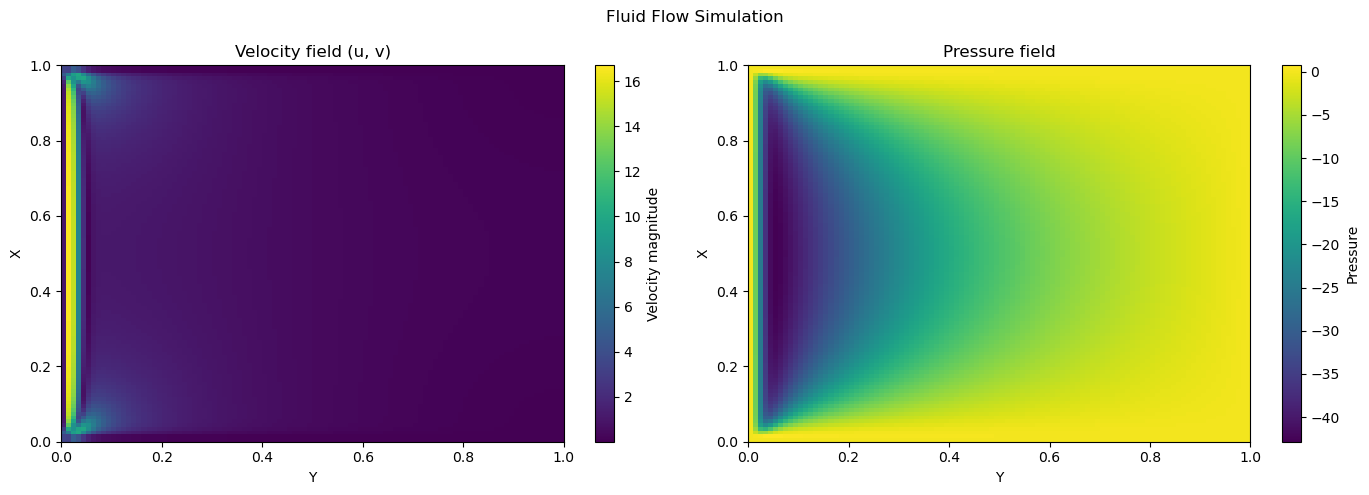

In [4]:
X , Y = np.meshgrid(np.linspace(0, 1, NX), np.linspace(0, 1, NY))

plot_simulation_results(u, v, p, X, Y)